In [20]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms

from utils import mnist, plot_graphs, plot_mnist, mnist_transform
import numpy as np

%matplotlib inline

In [2]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

In [3]:
train_loader, valid_loader, test_loader = mnist(valid=10000, transform=transforms.ToTensor())

In [4]:
class ConvLayer(nn.Module):
    def __init__(self, size, padding=1, pool_layer=nn.MaxPool2d(2, stride=2),
                 bn=False, dropout=False, activation_fn=nn.ReLU()):
        super(ConvLayer, self).__init__()
        layers = []
        layers.append(nn.Conv2d(size[0], size[1], size[2], padding=padding))
        if pool_layer is not None:
            layers.append(pool_layer)
        if bn:
            layers.append(nn.BatchNorm2d(size[1]))
        if dropout:
            layers.append(nn.Dropout2d())
        layers.append(activation_fn)
        
        self.model = nn.Sequential(*layers)
    
    def forward(self, x):
        return self.model(x)

In [5]:
class FullyConnected(nn.Module):
    def __init__(self, sizes, dropout=False, activation_fn=nn.Tanh):
        super(FullyConnected, self).__init__()
        layers = []
        
        for i in range(len(sizes) - 2):
            layers.append(nn.Linear(sizes[i], sizes[i+1]))
            if dropout:
                layers.append(nn.Dropout())
            layers.append(activation_fn())
        else: # нам не нужен дропаут и фнкция активации в последнем слое
            layers.append(nn.Linear(sizes[-2], sizes[-1]))
        
        self.model = nn.Sequential(*layers)
        
    def forward(self, x):
        return self.model(x)

In [6]:
class Net(nn.Module):
    def __init__(self, batchnorm=False, dropout=False, lr=1e-4, l2=0.):
        super(Net, self).__init__()
        
        
        self._conv1 = ConvLayer([1, 16, 3], bn=batchnorm)
        self._conv2 = ConvLayer([16, 32, 3], bn=batchnorm, activation_fn=nn.Sigmoid())
        
        self.fc = FullyConnected([32*7*7, 10], dropout=dropout)
        
        self._loss = None
        self.optim = optim.Adam(self.parameters(), lr=lr, weight_decay=l2)
    
    def conv(self, x):
        x = self._conv1(x)
        x = self._conv2(x)
        return x
        
    def forward(self, x):
        x = self.conv(x)
        x = x.view(-1, 32*7*7)
        x = self.fc(x)
        return x
    
    def loss(self, output, target, **kwargs):
        self._loss = F.cross_entropy(output, target, **kwargs)
        self._correct = output.data.max(1, keepdim=True)[1]
        self._correct = self._correct.eq(target.data.view_as(self._correct)).to(torch.float).cpu().mean()
        return self._loss

In [7]:
models = {'bn': Net(True), 'drop': Net(False, True), 'plain': Net()}
train_log = {k: [] for k in models}
test_log = {k: [] for k in models}

In [8]:
def train(epoch, models, log=None):
    train_size = len(train_loader.sampler)
    for batch_idx, (data, target) in enumerate(train_loader):
        for model in models.values():
            model.optim.zero_grad()
            output = model(data)
            loss = model.loss(output, target)
            loss.backward()
            model.optim.step()
            
        if batch_idx % 200 == 0:
            line = 'Train Epoch: {} [{}/{} ({:.0f}%)]\tLosses '.format(
                epoch, batch_idx * len(data), train_size, 100. * batch_idx / len(train_loader))
            losses = ' '.join(['{}: {:.6f}'.format(k, m._loss.item()) for k, m in models.items()])
            print(line + losses)
            
    else:
        batch_idx += 1
        line = 'Train Epoch: {} [{}/{} ({:.0f}%)]\tLosses '.format(
            epoch, batch_idx * len(data), train_size, 100. * batch_idx / len(train_loader))
        losses = ' '.join(['{}: {:.6f}'.format(k, m._loss.item()) for k, m in models.items()])
        if log is not None:
            for k in models:
                log[k].append((models[k]._loss, models[k]._correct))
        print(line + losses)

In [9]:
def test(models, loader, log=None):
    test_size = len(loader.sampler)
    avg_lambda = lambda l: 'Loss: {:.4f}'.format(l)
    acc_lambda = lambda c, p: 'Accuracy: {}/{} ({:.0f}%)'.format(c, test_size, p)
    line = lambda i, l, c, p: '{}: '.format(i) + avg_lambda(l) + '\t' + acc_lambda(c, p)

    test_loss = {k: 0. for k in models}
    correct = {k: 0. for k in models}
    with torch.no_grad():
        for data, target in loader:
            output = {k: m(data) for k, m in models.items()}
            for k, m in models.items():
                test_loss[k] += m.loss(output[k], target, reduction='sum').item() # sum up batch loss
                pred = output[k].data.max(1, keepdim=True)[1] # get the index of the max log-probability
                correct[k] += pred.eq(target.data.view_as(pred)).cpu().sum().item()
    
    for k in models:
        test_loss[k] /= test_size
    correct_pct = {k: c / test_size for k, c in correct.items()}
    lines = '\n'.join([line(k, test_loss[k], correct[k], 100*correct_pct[k]) for k in models]) + '\n'
    report = 'Test set:\n' + lines
    if log is not None:
        for k in models:
            log[k].append((test_loss[k], correct_pct[k]))
    print(report)

In [10]:
for epoch in range(1, 41):
    for model in models.values():
        model.train()
    train(epoch, models, train_log)
    for model in models.values():
        model.eval()
    test(models, valid_loader, test_log)

Train Epoch: 1 [0/50000 (0%)]	Losses bn: 2.362737 drop: 2.377130 plain: 2.282557
Train Epoch: 1 [10000/50000 (20%)]	Losses bn: 1.990435 drop: 2.246399 plain: 2.273193
Train Epoch: 1 [20000/50000 (40%)]	Losses bn: 1.708242 drop: 2.015078 plain: 2.163042
Train Epoch: 1 [30000/50000 (60%)]	Losses bn: 1.439820 drop: 1.611396 plain: 1.868464
Train Epoch: 1 [40000/50000 (80%)]	Losses bn: 1.251778 drop: 1.181131 plain: 1.442492
Train Epoch: 1 [50000/50000 (100%)]	Losses bn: 1.056960 drop: 0.960436 plain: 1.117600
Test set:
bn: Loss: 0.9836	Accuracy: 8796.0/10000 (88%)
drop: Loss: 0.8582	Accuracy: 8202.0/10000 (82%)
plain: Loss: 1.0488	Accuracy: 7791.0/10000 (78%)

Train Epoch: 2 [0/50000 (0%)]	Losses bn: 0.926027 drop: 0.806486 plain: 0.982784
Train Epoch: 2 [10000/50000 (20%)]	Losses bn: 0.857876 drop: 0.761056 plain: 0.913914
Train Epoch: 2 [20000/50000 (40%)]	Losses bn: 0.663757 drop: 0.553715 plain: 0.642904
Train Epoch: 2 [30000/50000 (60%)]	Losses bn: 0.611922 drop: 0.553143 plain: 0.66

Train Epoch: 13 [30000/50000 (60%)]	Losses bn: 0.060235 drop: 0.097620 plain: 0.105674
Train Epoch: 13 [40000/50000 (80%)]	Losses bn: 0.135126 drop: 0.250290 plain: 0.277181
Train Epoch: 13 [50000/50000 (100%)]	Losses bn: 0.054464 drop: 0.065775 plain: 0.068208
Test set:
bn: Loss: 0.0651	Accuracy: 9812.0/10000 (98%)
drop: Loss: 0.1131	Accuracy: 9701.0/10000 (97%)
plain: Loss: 0.1180	Accuracy: 9676.0/10000 (97%)

Train Epoch: 14 [0/50000 (0%)]	Losses bn: 0.066461 drop: 0.138087 plain: 0.168012
Train Epoch: 14 [10000/50000 (20%)]	Losses bn: 0.136711 drop: 0.233365 plain: 0.241821
Train Epoch: 14 [20000/50000 (40%)]	Losses bn: 0.075796 drop: 0.134434 plain: 0.125084
Train Epoch: 14 [30000/50000 (60%)]	Losses bn: 0.226466 drop: 0.331750 plain: 0.332085
Train Epoch: 14 [40000/50000 (80%)]	Losses bn: 0.037340 drop: 0.064549 plain: 0.087667
Train Epoch: 14 [50000/50000 (100%)]	Losses bn: 0.062114 drop: 0.189053 plain: 0.200444
Test set:
bn: Loss: 0.0648	Accuracy: 9818.0/10000 (98%)
drop: Loss

KeyboardInterrupt: 

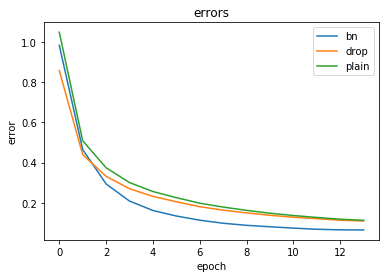

In [11]:
plot_graphs(test_log, 'loss')

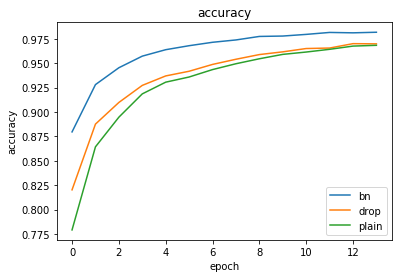

In [12]:
plot_graphs(test_log, 'accuracy')

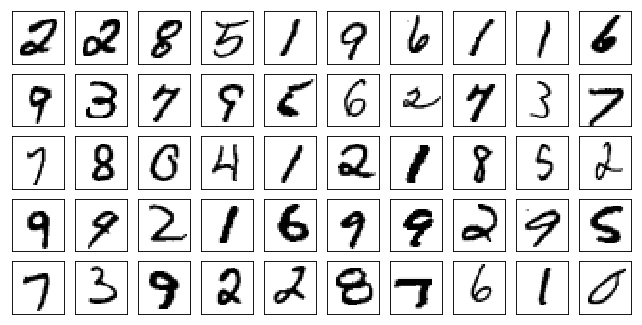

tensor([-1.8842, -6.3843,  5.6692, -2.3702, -8.0887, -7.3383, -5.5834, -4.5614,
        -1.2521, -5.3970], grad_fn=<SelectBackward>)


In [14]:
data, label = next(iter(train_loader))
plot_mnist(data.data.numpy(), (5, 10))
output = models['bn'](data)
output.size()
print(output[0])
#to_plot = output.view(-1, 1, 28, 28).clamp(0, 1).data.numpy()
#plot_mnist(to_plot, (5, 10))

### Подгонка картинки или Сделать оптимизацию изображения под активацию сверточных нейронов классификатора

In [23]:
path='./MNIST_data'
from torch.utils.data import DataLoader
train_dataset = torchvision.datasets.MNIST(root = path, train=True, transform=mnist_transform, download=True) 
train_loader_1 = DataLoader(dataset=train_dataset, batch_size=1,shuffle=True) 
data_1, label_1 = next(iter(train_loader_1))

In [32]:
# Обернем в Variable и потребуем градиентов
from torch.autograd import Variable
data_t = Variable(torch.FloatTensor( data_1 ), requires_grad=True)

In [104]:
# Целевой пусть будет циферка 3
target_test = torch.LongTensor([3])

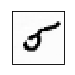

tensor(7.8396)


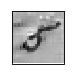

tensor(0.0225)


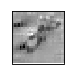

tensor(0.0064)


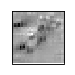

tensor(0.0091)


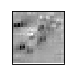

tensor(0.0050)


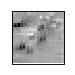

tensor(0.0039)


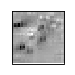

tensor(0.0039)


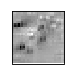

tensor(0.0042)


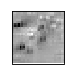

tensor(0.0036)


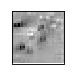

tensor(0.0032)


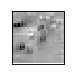

tensor(0.0029)


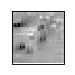

tensor(0.0027)


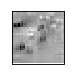

tensor(0.0025)


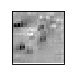

tensor(0.0023)


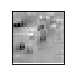

tensor(0.0024)


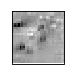

tensor(0.0025)


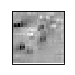

tensor(0.0026)


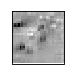

tensor(0.0025)


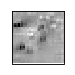

tensor(0.0022)


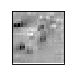

tensor(0.0020)


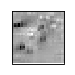

tensor(0.0017)


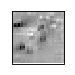

tensor(0.0016)


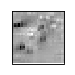

tensor(0.0016)


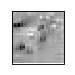

tensor(0.0015)


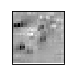

tensor(0.0015)


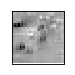

tensor(0.0014)


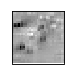

tensor(0.0014)


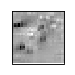

tensor(0.0013)


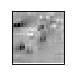

tensor(0.0013)


KeyboardInterrupt: 

In [105]:
# Cross entropy
lr = 0.3
output_ar = []
loss_arr = []
grads = []
data_t = Variable(torch.FloatTensor( data_1 ), requires_grad=True)
for i in range(0,200000):
    output_o = model(data_t)
    loss_t = F.cross_entropy(output_o, target_test)
    loss_t.backward()
    data_t.data = data_t.data - (lr*data_t.grad.data)
    #grads.append(data_t.grad.data)
    #loss_arr.append(loss_t.data)
    #output_ar.append(output_o)
    data_t.grad.data.zero_
    if i % 10 == 0:
        plot_mnist(data_t.data.numpy(), (5, 10))
        print(loss_t.data)
plot_mnist(data_t.data.numpy(), (5, 10))

In [107]:
# Проверка, что это все таки тройка :)
output_o = model(data_t)
print(output_o)

tensor([[-8.1167, -4.6271,  1.0849,  8.6191, -9.7554, -8.0858, -9.5495,  1.4100,
         -4.4337, -3.8223]], grad_fn=<AddmmBackward>)


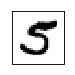

tensor(1.4414)


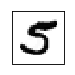

tensor(1.3824)


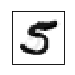

tensor(1.2287)


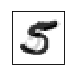

tensor(1.0023)


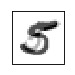

tensor(0.7356)


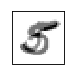

tensor(0.4667)


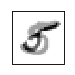

tensor(0.2343)


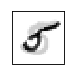

tensor(0.0715)


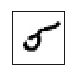

tensor(0.0017)


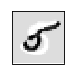

tensor(0.0348)


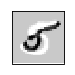

tensor(0.1662)


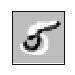

tensor(0.3770)


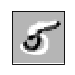

tensor(0.6370)


KeyboardInterrupt: 

In [109]:
# For fun MSE_loss - как-то странно получается
lr = 0.3
output_ar = []
loss_arr = []
grads = []
data_2,label = next(iter(train_loader_1))
data_t = Variable(torch.FloatTensor( data_2 ), requires_grad=True)
for i in range(0,200000):
    #data_t.grad.data.zero_
    #output_o = model(data_t)
    loss_t = F.mse_loss(data_t, data_1)
    loss_t.backward()
    data_t.data = data_t.data - (lr*data_t.grad.data)
    #grads.append(data_t.grad.data)
    loss_arr.append(loss_t.data)
    #output_ar.append(output_o)
    data_t.grad.data.zero_
    if i % 10000 == 0:
        plot_mnist(data_t.data.numpy(), (5, 10))
        print(loss_t.data)
plot_mnist(data_t.data.numpy(), (5, 10))

In [110]:
#for param in model.parameters():
  #print(param.data, param.data.size())